# Genetic Algorithms

This notebook covers in depth how genetic algorithms works. This notebook provides examples, theorems, proofs, solutions and code.

## Explanation

### Introduction

In computer science and operations research, a genetic algorithm (GA) is a metaheuristic inspired by the process of natural selection that belongs to the larger class of evolutionary algorithms. Genetic algorithms are commonly used to generate high-quality solutions to optimization and search problems via biologically inspired operators such as selection, crossover, and mutation. They can be very efficient and really easy to implement. Moreover, there are only few things to changes in a GA for two differents problems.

In [1]:
# Some usefull packages we will use
import matplotlib.pyplot as plt
import random as rd
import math
import time
from IPython import display

### Optimisation problem

GA are made for optimization problem, i.e. for problem of the form:

Let $\mathcal{C}$ be the feasible set of solutions (the set of solutions that satisfy the contraints of the problem).

Let $f: \mathcal{C} \rightarrow \mathbb{R}$ be the function of which we want to find the maximum.

We want $$\underset{x\in\mathcal{C}}{argmax} \{f(x)\}$$

For the next explanations, we will try to find the maximum value of a simple function
$$f: \begin{cases}
      [-5,3] \rightarrow \mathbb{R}\\
      x \mapsto -x^4 -3x^3 +10x^2 +6x -4
    \end{cases}$$

In [2]:
f = lambda x: -x**4 -3*x**3 +10*x**2 +6*x -4
f_min = -5
f_max = 3

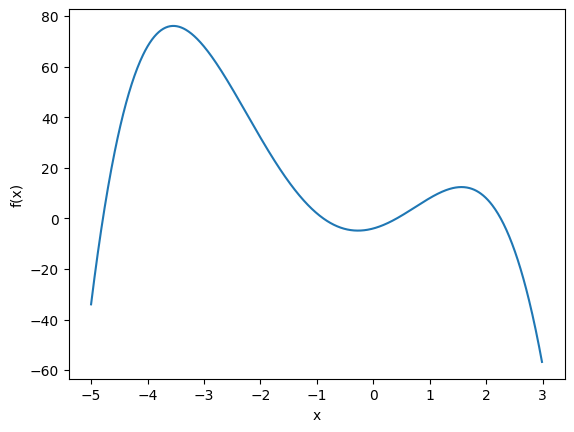

In [3]:
def plot_f(show=True, f_min=f_min, f_max=f_max, ratio=100):
    ratio = int(ratio)
    x = [x/ratio for x in range(int(f_min*ratio), int(f_max*ratio))]
    y = [f(x) for x in x]
    plt.plot(x, y, "-")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    if show:
        plt.show()
plot_f()

The **objective function** of a GA problems is the function we try to optimize (i.e. to find the minimum or the maximum). Here, the objective function is $f$.

### Objective function/Score

The **Objective function** (also called **score**) of a solution $x\in \mathcal{C}$ is the value attributed to the solution depending of how well it is. We denote by $\mathcal{S}(x)$ the score of $x$. Then, we always want to find the maximum of the objective function.

In our problem, $\mathcal{S}: x \mapsto f(x)$ is the objective function. If you want to find the minimum of $f$, simply find the maximum of $-f$.

We says that a solution $x$ is **better** than a solution $y$ (denoted as $x \preceq y$) if and only if $\mathcal{S}(x) \geq \mathcal{S}(y)$. A solution $x$ is **strickly better** than a solution $y$ (denoted as $x \prec y$) if and only if $\mathcal{S}(x) > \mathcal{S}(y)$.

The **best solution** is $\underset{x\in\mathcal{C}}{argmax} \{\mathcal{S}(x)\}$.

In [4]:
def S(x):
    return f(x)  # to find the maximum of f
    # return -f(x) # to find the minimum of f

### Generation

#### Population

A **population** $P$ is a set of feasible solutions. $\forall k \leq  |P|$, we denote by $P[k]$ the $k$-th better solution of $P$. Then, $\forall i,j$, if $i\leq j$ then $P[i] \preceq P[j]$.

It is equivalent to said that $P$ is a vector sorted with the function $x \mapsto -\mathcal{S}(x)$.

Genetic algorithms follow the natural selection process. Then it takes a population $P_n$ and try to construct an other population $P_{n+1}$ based on the best solutions of $P_n$. We will contructed the population $P_{n+1}$ by keeping a proportion $\varepsilon_0$ of the best solutions of $P_n$, adding $\varepsilon_1$ cross-over, $\varepsilon_2$ mutations and $\varepsilon_3$ random new solutions. With $\varepsilon_0,\varepsilon_1,\varepsilon_2,\varepsilon_3$ some constant $\in [0,1]$. Going from $P_n$ to $P_{n+1}$ is called a generation. We will repeat this a fixed `NB_GEN` $\in \mathbb{N}$ number of time.

A genetic algorithm is the following:
 - Construct a first random population $P_0$
 - for i=1 to M:
    - construct $P_{i+1}$ from $P_{i}$
 - return $P_M$

For the programation part, we want all the population to have a fixed size `LEN_POP` $\in \mathbb{N}$. Otherwise, population might overgrow and these leed to exponential times of computation. Then $\varepsilon_0 + \varepsilon_1 + \varepsilon_2 + \varepsilon_3 =$ `LEN_POP`.

In [5]:
LEN_POP = 100
NB_GEN = 15

#### Cenerate solution

As said previously, we want to be able to generate random solution and random population for our problem. Nevertheless, the score function can take a long time to be compute, therefore, we want to calculate the score of a solution only once. Thus we will create a python class caleed `Solution` to store the solution and its score.

In [6]:
class Solution():
    def __init__(self, sol, score):
        self.sol = sol
        self.score = score

In [7]:
def gen_sol():
    x = rd.uniform(f_min, f_max) # Generate random real number between f_min and f_max
    return Solution(x, S(x))

def gen_pop():
    return [gen_sol() for _ in range(LEN_POP)]

Notice that the function `gen_pop()` stays the same no matter the problem.

Let's visualise a random population.

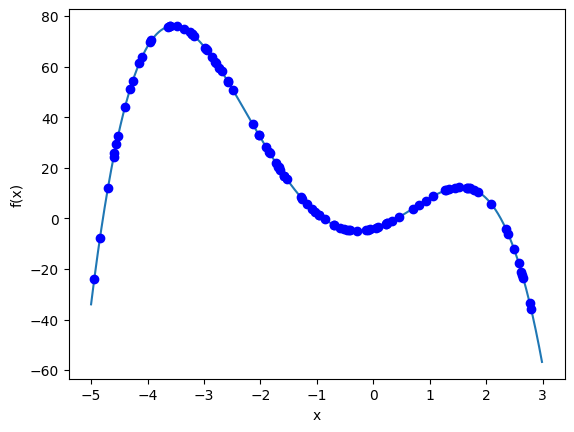

In [8]:
plot_f(show=False)
pop = gen_pop()

def plot_pop(pop, color, legend=""):
    solutions = [sol.sol for sol in pop]
    solutions_score = [S(sol) for sol in solutions]
    plt.plot(solutions, solutions_score, 'o', color=color, label=legend)

plot_pop(pop, "blue")
plt.show()

#### Cross-over

Genetic algorithms are based on two main heuristic: cross-over and mutation.

A **cross-over** of two solutions $x$ and $y$ is an other solution $\phi(x,y)$ such that $\phi(x,y)$ try to fit as best as possible the similarities of $x$ and $y$. A cross-over is the equivalent of natural reproduction. The cross-over of $x$ and $y$ is often called the **child** of $x$ and $y$.

For example:
 - if $\mathcal{C} = \mathbb{R}$, a good cross-over is $\phi : (x,y) \mapsto \frac{x+y}{2}$
 - if $\mathcal{C} = \mathbb{R}^n$, a good cross-over is $\phi : ((x_i)_{1\leq i\leq n},(y_i)_{1\leq i\leq n}) \mapsto (\frac{x_i+y_i}{2})_{1\leq i\leq n}$

You will see other example where the solution are some list, graphs or new class in tutorials.

In [9]:
def cross_over(x:Solution, y:Solution):
    z = (x.sol + y.sol)/2
    return Solution(z, S(z))

Let's visualize what some cross_over.

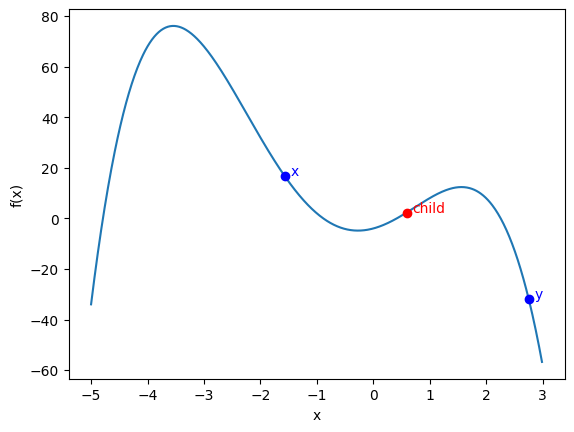

In [10]:
x = gen_sol()
y = gen_sol()
z = cross_over(x, y)

def plot_sol(x, color="blue", msg=""):
    plt.plot(x.sol, x.score, "o", color=color)
    plt.text(x.sol+0.1, x.score+0.3, msg, color=color)

plot_f(show=False)
plot_sol(x, msg="x")
plot_sol(y, msg="y")
plot_sol(z, color="red", msg="child")
plt.show()

#### Mutations

As you may know, in genetics, some mutation randomly appear and create new solution that can be better or worst.

The **mutation** of a solution $x$ is a slight modification $\psi(x)$ of $x$.

For example:
 - if $\mathcal{C} = \mathbb{R}$, a good cross-over is $\psi : x \mapsto x + \delta$, for some small $\delta \in \mathbb{R}$.
 - if $\mathcal{C} = \mathbb{R}^n$, a good cross-over is $\phi : (x_i)_{1\leq i\leq n} \mapsto (x_i+p\delta)_{1\leq i\leq n}$, for some small $\delta \in \mathbb{R}$ and $p = 1$ with some fix probability and $0$ otherwise.

You will see other example where the solution are some list, graphs or new class in tutorials.

In [11]:
def mutate(x: Solution):
    delta = rd.random()/2
    y = x.sol + delta * (-1) ** rd.randint(0,1)
    return Solution(y, S(y))

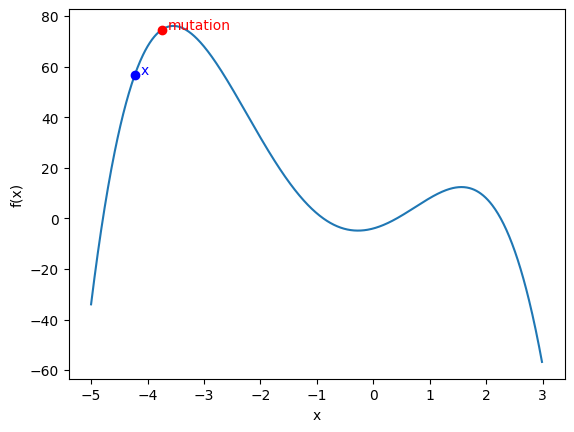

In [12]:
x = gen_sol()
y = mutate(x)

plot_f(show=False)
plot_sol(x, msg="x")
plot_sol(y, color="red", msg="mutation")
plt.show()

### Creating $P_{n+1}$

#### Sorting population

As said previously, we want that $\forall i,j$ such that $i\leq j$ we have $S(pop[i]) \geq S(pop[j])$. Then we want to sort the population `pop`.

In [13]:
def sort_pop(pop):
    pop.sort(key=lambda x:-x.score)

sort_pop(pop)

#### Constants

First we define all the constant $\varepsilon_0, \varepsilon_1, \varepsilon_2$ called hyperparameter with good value for this problem. If you do some reinforcment learning project, you will have to play with hyper parameter to find best solution in as less time as possible. Then $\varepsilon_3 = 1-\varepsilon_0 - \varepsilon_1 -  \varepsilon_2$.

Depending of the problem, you will want to add more mutations or cross_over.

In [14]:
epsilon_0 = 0.3
epsilon_1 = 0.3
epsilon_2 = 0.2
epsilon_3 = 1 - epsilon_0 - epsilon_1 - epsilon_2

print(epsilon_0, epsilon_1, epsilon_2, epsilon_3)

0.3 0.3 0.2 0.19999999999999996


#### Kept solutions

First, we will keep the $\varepsilon_0$ best solution of the population `pop`.

In [15]:
def np_keep(pop):
    new_pop = []
    for i in range(int(epsilon_0 * LEN_POP)):
        new_pop.append(pop[i])
    return new_pop

[]

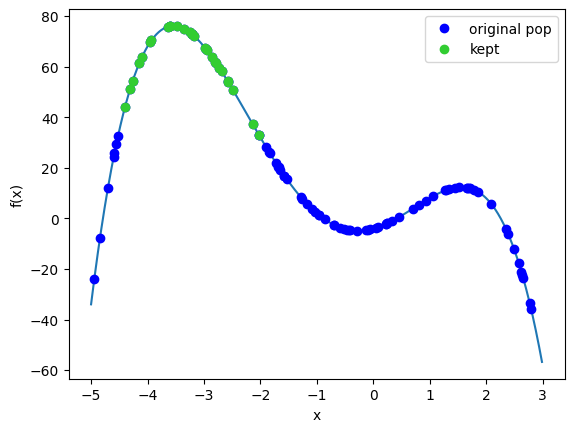

In [16]:
kept = np_keep(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(kept, "limegreen", "kept")
plt.legend(loc="upper right")
plt.plot()

#### Cross-Over

Note that its seems better to make child of two good solutions of $P_n$ than with two random solution of $P_n$.

Then we want a $K\in \mathbb{N}$ such that
$$|\{\phi(P_n[i], P_n[j]),\; i\in\{1,...,K\}, j \in \{i+1,...,K\}\}| = K$$

Therefore,
$$K = \lfloor \frac{1 + \sqrt{1+8\varepsilon_1}}{2} \rfloor$$

In [17]:
def np_cross_over(pop):
    new_pop = []
    K = int( (1 + math.sqrt(1 + 8*epsilon_1*LEN_POP)) / 2 )
    for i in range(K):
        for j in range(i+1, K):
            new_pop.append(cross_over(pop[i], pop[j]))
    return new_pop

[]

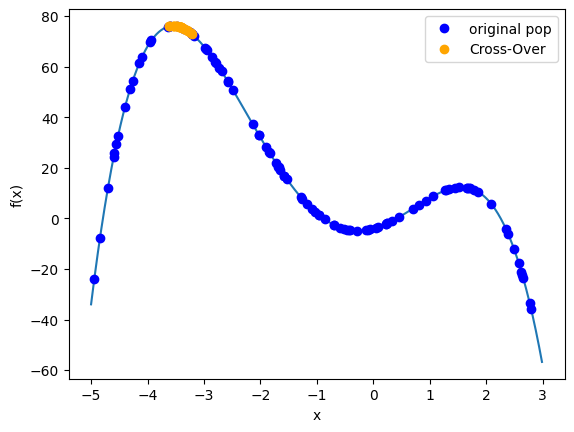

In [18]:
cross_overs = np_cross_over(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(cross_overs, "orange", "Cross-Over")
plt.legend(loc="upper right")
plt.plot()

#### Mutations

Similarily, its seems better to make mutations from the best solutions.

Then we want to add :
$$\{\psi(P_n[i]),\; i\in\{1,...,\lfloor \varepsilon_2 . LEN\_ POP\rfloor\}\}$$

In [19]:
def np_mutation(pop):
    new_pop = []
    for i in range(int(LEN_POP*epsilon_2)):
        new_pop.append(mutate(pop[i]))
    return new_pop

[]

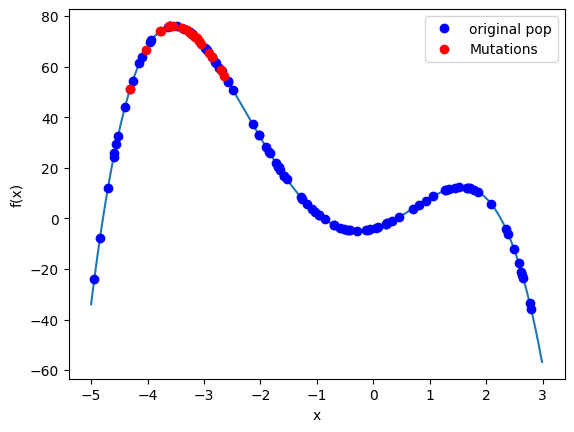

In [20]:
mutations = np_mutation(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(mutations, "red", "Mutations")
plt.legend(loc="upper right")
plt.plot()

#### New solutions

Then, we add the $\varepsilon_3$ new random solutions.

In [21]:
def np_new_solutions(pop):
    new_pop = []
    for _ in range(int(epsilon_3 * LEN_POP)):
        new_pop.append(gen_sol())
    return new_pop

[]

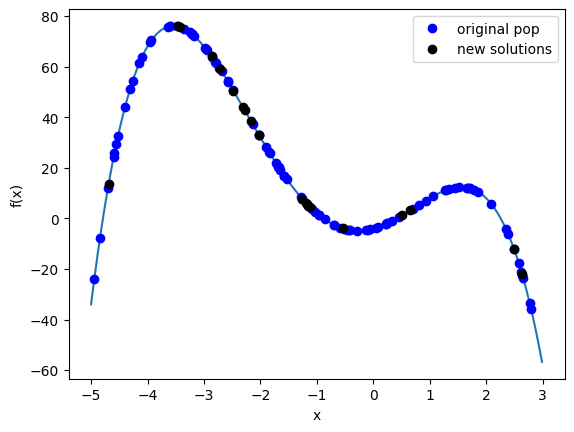

In [22]:
news = np_new_solutions(pop)
plot_f(False)
plot_pop(pop, "blue", "original pop")
plot_pop(news, "black", "new solutions")
plt.legend(loc="upper right")
plt.plot()

#### Complete function

In [23]:
def create_next_pop(pop, show=False):
    # pop is supposed to be sorted
    kept = np_keep(pop)
    cross_overs = np_cross_over(pop)
    mutations = np_mutation(pop)
    news = np_new_solutions(pop)
    
    if show: 
        plot_f(False)
        plot_pop(pop, "blue", "original pop")
        plot_pop(kept, "limegreen", "kept")
        plot_pop(cross_overs, "orange", "cross-over")
        plot_pop(mutations, "red", "mutation")
        plot_pop(news, "black", "new solutions")
        plt.legend(loc="upper right")
        plt.plot()
    new_pop = kept + cross_overs + mutations + news
    return new_pop

97


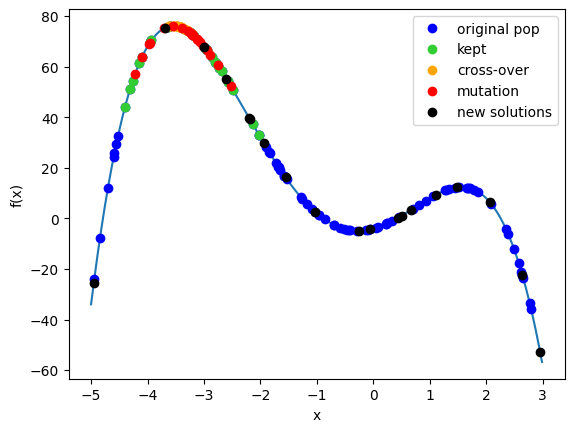

In [24]:
next_pop = create_next_pop(pop, True)
print(len(next_pop))

### Algorithm

Finally, we just have to compute the next generation `NB_GEN` time.

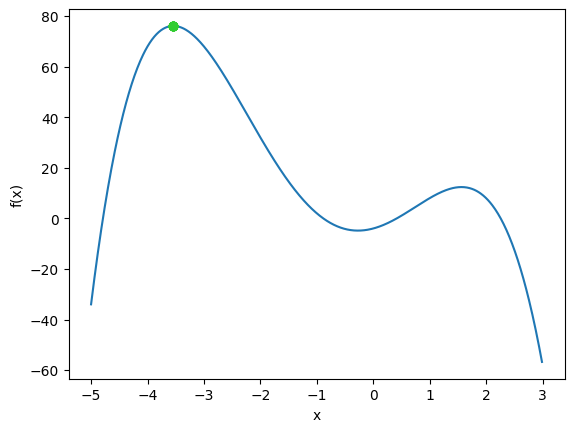

14 

In [25]:
def aglo_gen(show=False):
    pop = gen_pop()
    best_of_each_gen = [] #Store best solution of each generations
    for gen in range(NB_GEN):
        sort_pop(pop)
        best_of_each_gen.append(pop[0])
        pop = create_next_pop(pop)

        if show:
            plot_f(show=False)
            pop_to_print = pop[:10]
            plot_pop(pop_to_print, "limegreen")
            display.clear_output(wait=True)
            plt.show()
            time.sleep(0.1)
            print(gen, end=" ")
    return pop[0], best_of_each_gen #The best solution the algo found

best, best_of_each_gen = aglo_gen(show=True)

Then, we can plot the score of best solutions of each generation to the the evolution thanks to the variable `est_of_each_gen`.

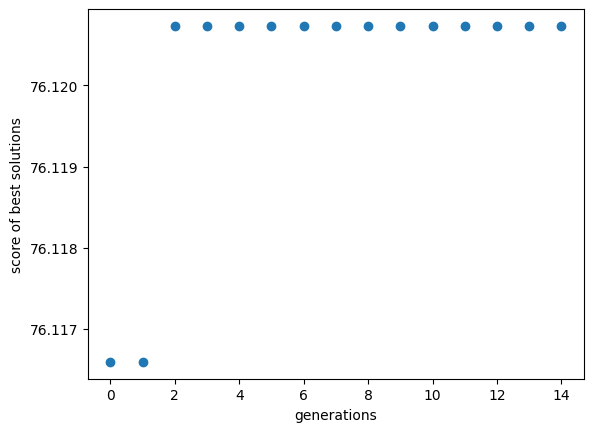

In [26]:
liste_gen = [i for i in range(NB_GEN)]
liste_y = [sol.score for sol in best_of_each_gen]

plt.plot(liste_gen, liste_y, "o")
plt.xlabel("generations")
plt.ylabel("score of best solutions")
plt.show()

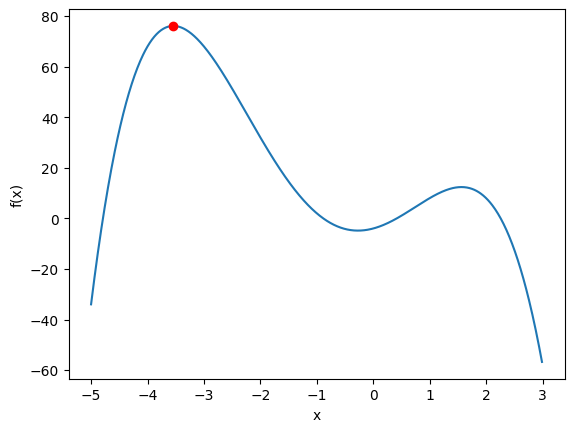

In [27]:
plot_f(False)
plt.plot(best.sol, best.score, "o", color="red")

Then a genetic algorithm can be simply represented with the next figure.

<img src="GeneticAlgoPrinciple.png" alt="drawing" width="600"/>

## Proof of genetic algorithm

The goal of this part is to show that genetic algorithm converge, i.e. to prove that genetic algorithm wroks. This part is only theoritical.

### Definitions

Let $x\in \mathcal{C}$ be a solution. The **neighboorhood** of $x$ denoted by $\mathcal{N}(x)$ defined as the set of all possible mutations and cross-over formed with $x$.

Let $x,y \in\mathcal{C}$ be two solutions. We says that $x$ **can reach** $y$ if there exist an integer $k\in\mathbb{N}$ and $k$ solutions $x_1,...,x_k$ such that $x_1 = x$, $x_k=y$ and $\forall i \in \{1,...,k-1\}$, $x_{i+1} \in \mathcal{N}(x_i)$.

### Convergence theorem

If $\forall x,y \in \mathcal{C}$, $x$ can reach $y$, then
$$\mathbb{P}(P_n[0] \text{is the optimal solution}) \underset{n \rightarrow +\infty}{\rightarrow} 1$$

### Proof

We define a markov chaine $(Y_n)_{n\in\mathbb{N}}$ as folowing:
 - A state of $(Y_n)_{n\in\mathbb{N}}$ is a population $y \in \mathcal{C}^N$ with $N$ the lenght of the populations.
 - Let $y_0$ be a special state such that if $Y_n = y_0$ then it means that the population of state $Y_n$ contain an optimal solution.

Now, the sequence of population of genetic algorithm can be discribe with this markov chains. $Y_n$ represent the population $P_n$.

Notice that the state $y_0$ is an absorbing state. In fact if $Y_n = y_0$ then it mean that $P_n[0]$ is optimal. Since we always kept the best solutions of previous populations, it means that $\forall n'>n$, we have that $P_{n'}[0]$ is optimal. Therefore, $\forall n'>n$, $Y_{n'} = y_0$. Moreover, $y_0$ is the only absorbing state $(Y_n)_{n\in\mathbb{N}}$.

Then, since $\forall x,y \in \mathcal{C}$, $x$ can reach $y$, then $\forall x \in \mathcal{C}$, $x$ can reach an optimal value. Then every state $y_n$ can reach state $y_0$.

Suppose that the set of state $\mathcal{C}^N$ is finite. Note that it can be true even for continuous function by descritise the set $\mathcal{C}$.

Then $\mathbb{P}(Y_n = y_0) \underset{n \rightarrow +\infty}{\rightarrow} 1$

Then $\mathbb{P}(P_n[0] \text{is the optimal solution}) \underset{n \rightarrow +\infty}{\rightarrow} 1$

### Remark

Notice that this theorem show that genetic algorithm will find the best solution one days but that it doesn't talk at all about the convergence speed of the algorithms. This is in fact really harder to tell somethings about convergence speed. There are no general result, i.e. it depend of your current problem and have to do with the notion of mixing-times of markov chain.

## Exercice and Class

### Genetic Algorithm class

We provide you a class named `GeneticAlgo` and `Solution` for coding genetic algorithm (you can see the code).

In [28]:
from GeneticAlgo import Solution, GeneticAlgo

To use this class, you have to create a subclass of `GeneticAlgo`.

In [29]:
class MyAlgo(GeneticAlgo):
    def __init__(self, nb_gen=15, len_pop=100):
        super().__init__(nb_gen, len_pop)

Then, you have to define the function `score()` that return the score of a solution (a float number), `gen_sol()` which generate a solution, `mutation()` that take an individu and return an other one and finally `cross_over()` that take two solutions and return a third one. If you want to define several ways to mutate solutions and make cross-over, then create those methods and choose between each one with some probability.

The method `algo()` return the last population after computing the generations and a list of the best solutions for each generations.

### Exercice 1

Use the provided class to find the maximum of previous function and plot it.

#### Solution

In [30]:
class MyAlgo(GeneticAlgo):
    def __init__(self, nb_gen=10, len_pop=100):
        super().__init__(nb_gen, len_pop)

    def score(self, x):
        return f(x)
        
    def gen_sol(self):
        x = rd.uniform(f_min, f_max)
        return Solution(x, self.score(x))

    def cross_over(self, x, y):
        z = (x.sol+y.sol)/2
        return Solution(z, self.score(z))
    
    def mutate(self, x):
        z = x.sol + (-1)**rd.randint(0,1) * rd.random()/2
        return Solution(z, self.score(z))

MA = MyAlgo()
last_pop = MA.algo(gen=1)

0 1 2 3 4 5 6 7 8 9 

To see the best solution we found, we can write:

In [31]:
best_sol = last_pop[0]
print(best_sol.sol, best_sol.score)
plot_f(False)
plt.plot(best_sol.sol, best_sol.score, "o", color="red")
plt.show()

AttributeError: 'list' object has no attribute 'sol'

To plot the evolution of best solution, you can write:

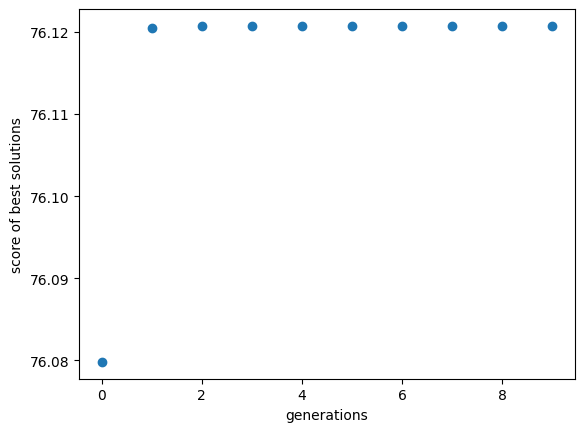

In [88]:
MA.plot_best_each_gen()

### Exercice 2

TODO: use those two class to find the minimum of the following function.

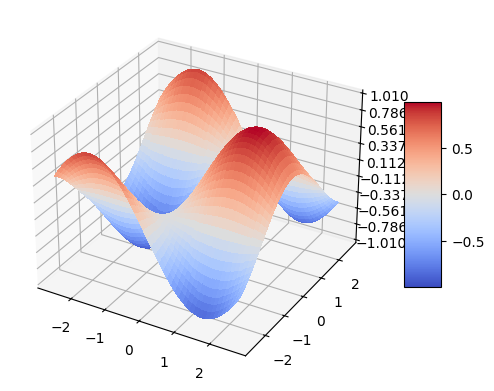

In [89]:
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator


def f(x,y):
    return np.sin(x) * np.cos(y)

f_min = -np.pi/1.2
f_max = np.pi/1.2

def plot_f():
    ratio = 100
    X = np.arange(f_min, f_max, 1/ratio)
    Y = np.arange(f_min, f_max, 1/ratio)
    X, Y = np.meshgrid(X, Y)
    Z = f(X,Y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # Customize the z axis.
    ax.set_zlim(-1.01, 1.01)
    ax.zaxis.set_major_locator(LinearLocator(10))
    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    
plot_f()
plt.show()

#### Solution

[1.568389226979475, 0.002245352086418441] 0.9999945821420041


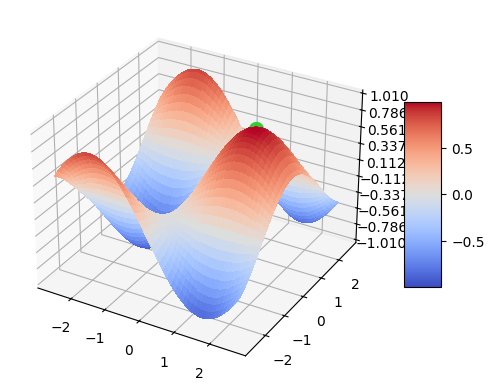

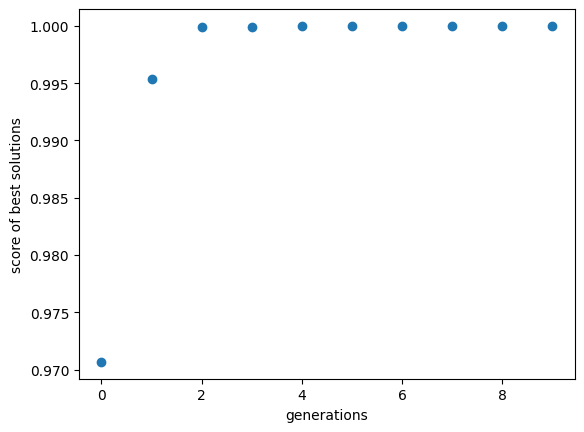

In [91]:
class MyAlgo(GeneticAlgo):
    def __init__(self, nb_gen=10, len_pop=100):
        super().__init__(nb_gen, len_pop)

    def score(self, x, y):
        return f(x, y)
        
    def gen_sol(self):
        x = rd.uniform(f_min, f_max)
        y = rd.uniform(f_min, f_max)
        return Solution([x,y], self.score(x,y))

    def cross_over(self, x, y):
        co_x = (x.sol[0]+y.sol[0])/2
        co_y = (x.sol[1]+y.sol[1])/2
        return Solution([co_x, co_y], self.score(co_x, co_y))
    
    def mutate(self, x):
        co_x = x.sol[0] + (-1)**rd.randint(0,1) * rd.random()/2
        co_y = x.sol[1] + (-1)**rd.randint(0,1) * rd.random()/2
        return Solution([co_x, co_y], self.score(co_x, co_y))
    
MA = MyAlgo()
last_pop = MA.algo(gen=20) #gen> nb_gen means that we don't print any index of generations
best_sol = last_pop[0]
print(best_sol.sol, best_sol.score)

plot_f()
plt.plot(best_sol.sol[0], best_sol.sol[1], best_sol.score, "o", color="limegreen", markersize=10)
plt.show()

MA.plot_best_each_gen()

### Exercice 3

Let $n=3$ and $V = \begin{bmatrix}
    12\\
    37\\
    15
\end{bmatrix} \in \mathcal{M}_n(\mathbb{R})$. Let $\mathcal{C} = \mathcal{M}_n(\{-K,...-1,1,...,K\})$ for $K=1000$.. Note that the solution must be non-zero integer matrix and not real matrix.

Remenber that $\forall X \in \mathcal{C}$, $V^\top . X = \underset{i=1}{\overset{n}{\sum}} V_{i,1}.X_{i,1}$

Find $\underset{X\in\mathcal{C}}{argmin}\{|V^\top . X|\}$

In [92]:
n = 3
K = 1000
V = (12, 37, 15)

#### Solution

gen n°0: -13
gen n°1: -2
gen n°2: 0
gen n°3: 0
gen n°4: 0
gen n°5: 0
gen n°6: 0
gen n°7: 0
gen n°8: 0
gen n°9: 0
[32, -117, 21] 0


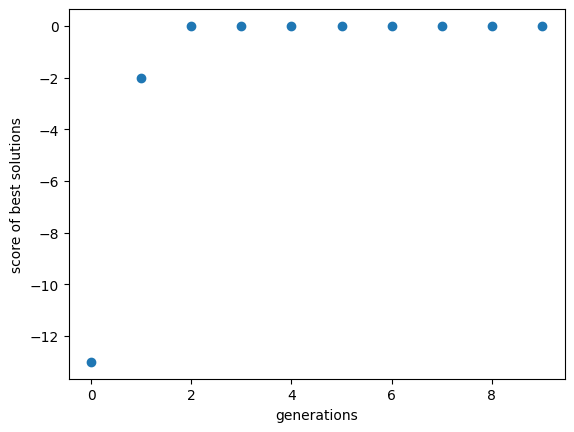

In [96]:
class MyAlgo(GeneticAlgo):
    def __init__(self, nb_gen=10, len_pop=100):
        super().__init__(nb_gen, len_pop)
        
    def score(self, x):
        sum = 0
        for i in range(n):
            sum += V[i] + x[i]
        return - np.absolute(sum) #we write a - because we want to find the minimum
        
    def gen_sol(self):
        x = [(-1)**rd.randint(0,1) * rd.randint(1,K) for _ in range(n)]
        return Solution(x, self.score(x))

    def cross_over(self, x, y):
        z = [0 for _ in range(n)]
        for i in range(n):
            new_val = int(round((x.sol[i]+y.sol[i])/2))
            if new_val == 0:
                new_val += (-1)**rd.randint(0,1)
            z[i] = new_val
        return Solution(z, self.score(z))
    
    def mutate(self, x):
        z = [x.sol[i] for i in range(n)]
        for i in range(n):
            if rd.random() <= 0.4:
                z[i] = (-1)**rd.randint(0,1) * rd.randint(1,K)
        return Solution(z, self.score(z))
    
    def fct_during_gen(self, actual_gen, actual_pop):
        # This is the function that will we call at each generation
        print("gen n°" + str(actual_gen) +":", actual_pop[0].score)
    
MA = MyAlgo()
last_pop = MA.algo(gen=1)
best_sol = last_pop[0]
print(best_sol.sol, best_sol.score)

MA.plot_best_each_gen()